# Table of Contents

# 1. Load data

# 2. Prepare data

# 3. Building a baseline model

# 4. Making predictions and evaluating

# 5. Setup device

# 6. Adding non-linearity

# 7. Convolutional Neural Network

# 8. Comparing our models

# 9. Evaluating our best model

# 10. Confusion matrix

##### When it comes to computer vision problems, PyTorch has several libraries that you need to know such as torchvision and its sub libraries.
##### Let us import the necessary libraries first.

In [2]:
import torch 
from torch import nn 

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

# 1. Load data

##### For this notebook, we will be using the FashionMNIST dataset.
##### It contains grayscale images of 10 differnt kinds of clothing.
##### So it is a multi-class classification task. 
##### Let us download the dataset using torchvision.datasets.FashionMNIST()

In [3]:
# Training data
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

# Testing data
test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

##### Let's check out the first sample of the training data.

In [4]:
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

##### Let's take a look at the shape of this huge tensor.

In [5]:
image.shape

torch.Size([1, 28, 28])

##### This means we have one color channel with 28 pixels on both of its axes.
##### The order of the shape can be interpreted as **Color Channels, Height, Width**.

In [6]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

##### We have 60,000 training data in total and 10,000 testing data in total.

In [7]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

##### And these are the classes we have, 10 in total.

##### We can also visualize what some of these pictures might look like.

Image shape: torch.Size([1, 28, 28])


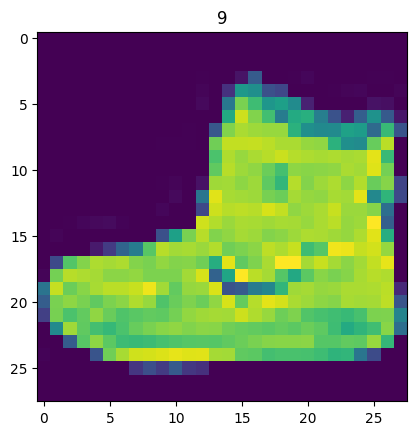

In [8]:
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze()) # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(label);

##### We can look at the original grayscale image.

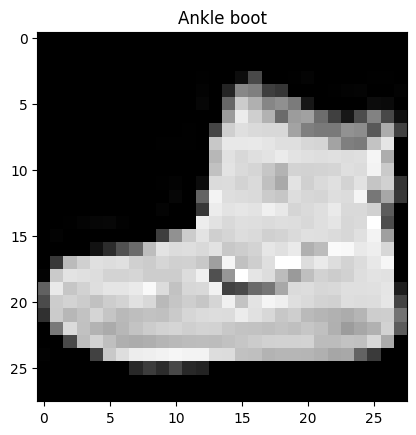

In [9]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label]);

##### Now that we know what our targets look like, let's prepare our data.

# 2. Prepare data

##### Here, we will be using **torch.utils.data.DataLoader**.
##### In short, this function is what helps us to load data into a model.
##### It turns a large dataset into a python iterable of smaller chunks, whic are referred to as batches or mini-batches.
##### This is more efficient computationally as passing through all data at once won't be welcomed by your computer.
##### Generally, 32 is a good batch size for most problems.
##### Usually the batch size can be any power of 2 but this depends on the user.

In [10]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle=True)

test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# 3. Building a baseline model

##### A baseline model is the simplest model we can build.
##### For now, it will just have two nn.Linear() layers.
##### But since we are working with image data, we're going to be using a different layer to start things off.
##### We would have the use the nn.Flatten() layer.
##### This layer would be in charge of compressing the dimensions of a tensor into a single vector.

In [11]:
flatten_model = nn.Flatten()

train_features_batch, train_labels_batch = next(iter(train_dataloader))
x = train_features_batch[0]

output = flatten_model(x)

print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


##### This has to be performed to change our height and width dimensions into one long feature vector. 
##### So now, there would be 784 feature variables in total.

In [12]:
class FashionMNISTV0(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.Linear(hidden_units, output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [13]:
torch.manual_seed(42)

model_0 = FashionMNISTV0(784, 10, len(class_names))

model_0.to("cpu")

FashionMNISTV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

##### Let's bring in some helper function.

In [14]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [15]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy()

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

##### Let's implement our training loop now.

In [16]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train() 
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X)
           
            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time      
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

/Users/kimhyunbin/Documents/Python/My own project (Python)/PyTorch/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|███▎      | 1/3 [00:01<00:03,  1.92s/it]


Train loss: 0.59039 | Test loss: 0.50954, Test acc: 82.04%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|██████▋   | 2/3 [00:03<00:01,  1.89s/it]


Train loss: 0.47633 | Test loss: 0.47989, Test acc: 83.20%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


Train loss: 0.45503 | Test loss: 0.47664, Test acc: 83.43%

Train time on cpu: 5.676 seconds


##### Our baseline model seems to have done ok as a start.

# 4. Making predictions and evaluating

##### Let's make a function that encompasses the whole evaluating/testing process.

In [17]:
torch.manual_seed(42)

def eval_model(model:torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                accuracy_fn):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            y_pred = model(X)

            loss += loss_fn(y_pred,y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, 
            "model_loss": loss.item(),
            "model_acc": acc}

model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results

{'model_name': 'FashionMNISTV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

##### An easy method for a one step evaluation!

# 5. Setup device

##### With Deep Learning, they are usually done with the help of a GPU.
##### But as I mentioned previously, since I'm using a macbook, I will be using the MPS from Apple.

In [18]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device('cpu')
device

device(type='mps')

# 6. Adding non-linearity

##### We saw the power of adding non-linearity into our model in the previous notebook.
##### So let us add the Relu function, nn.ReLU(), in between each linear layer.

In [23]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self,input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, output_shape),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layer_stack(x)

##### Let's load our new model onto MPS

In [24]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(784, 10, len(class_names)).to(device)
next(model_1.parameters()).device

device(type='mps', index=0)

## Let's set up the loss, optimizer and evaluation metrics.

In [25]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_1.parameters(),
lr = 0.01)

## Training and Testing loop

In [29]:
def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device = device):
    train_loss, train_acc = 0, 0
    for batch, (X,y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss+=loss
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
    
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train Loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader, model, loss_fn, accuracy_fn, device=device):
    test_loss, test_acc = 0, 0
    model.eval()

    with torch.inference_mode():
        for X,y in data_loader:
            X, y = X.to(device), y.to(device)

            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y, test_pred.argmax(dim=1))
    
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

##### Let's run the code using MPS and check how long it takes.

In [32]:
torch.manual_seed(42)

from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----")
    train_step(data_loader = train_dataloader, model =model_1, 
    loss_fn = loss_fn, optimizer = optimizer, accuracy_fn = accuracy_fn)
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----
Train Loss: 0.90456 | Train accuracy: 67.08%


 33%|███▎      | 1/3 [00:05<00:11,  5.81s/it]

Test loss: 0.92040 | Test accuracy: 66.51%

Epoch: 1
-----
Train Loss: 0.89381 | Train accuracy: 67.36%


 67%|██████▋   | 2/3 [00:11<00:05,  5.75s/it]

Test loss: 0.91260 | Test accuracy: 66.36%

Epoch: 2
-----
Train Loss: 0.88470 | Train accuracy: 67.56%


100%|██████████| 3/3 [00:17<00:00,  5.74s/it]

Test loss: 0.91010 | Test accuracy: 66.52%

Train time on mps: 17.221 seconds


##### Now, let's evaluate our model.

In [34]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn, 
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 1 results with device-agnostic code 
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device=device
)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.910102903842926,
 'model_acc': 66.52356230031948}

##### It looks like our model is not performing better than the original, basic model.
##### It seems like it's about time we learn about the Convolutional Neural Network (CNN)

##### The typical structure would look something like this:
##### Input layer -> Convolutional Layer -> Activation layer -> pooling layer -> Output layer

In [43]:
class Cnn(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(input_shape,hidden_units,3,1,1), # 28 x 28 x hidden_units
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3,1,1), # 28 x 28 x hidden_units
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 14 x 14 x hidden_units
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1), # 14 x 14 x hidden_units
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1), # 14 x 14 x hidden_units
            nn.ReLU(),
            nn.MaxPool2d(2) # 7 x 7 x hidden_units
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

torch.manual_seed(42)
model_2 = Cnn(input_shape = 1, hidden_units = 10, output_shape = len(class_names)).to(device)
model_2

Cnn(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

##### It is really important to keep track of the total number of features that is being calculated throughout the model.
##### You will need to write down how many nodes there are when you flatten them in the end.

In [44]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_2.parameters(), lr = 0.1)

##### Let's put our CNN model to the test!

In [45]:
epochs = 3
for epoch in tqdm(range(epochs)):
    train_step(data_loader = train_dataloader,
                model = model_2,
                loss_fn = loss_fn,
                optimizer=optimizer,
                accuracy_fn=accuracy_fn,
                device = device)
    test_step(data_loader=test_dataloader,
                    model = model_2,
                    loss_fn=loss_fn,
                    accuracy_fn=accuracy_fn,
                    device = device)
    

  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.57906 | Train accuracy: 79.07%


 33%|███▎      | 1/3 [00:10<00:21, 11.00s/it]

Test loss: 0.38724 | Test accuracy: 85.61%

Train Loss: 0.35557 | Train accuracy: 87.28%


 67%|██████▋   | 2/3 [00:21<00:10, 10.48s/it]

Test loss: 0.36830 | Test accuracy: 86.25%

Train Loss: 0.31745 | Train accuracy: 88.50%


100%|██████████| 3/3 [00:31<00:00, 10.41s/it]

Test loss: 0.32704 | Test accuracy: 88.13%



##### It seems like our model improved by a lot!

In [46]:
# Get model_2 results 
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'Cnn',
 'model_loss': 0.3270363211631775,
 'model_acc': 88.12899361022365}